# Before running this notebook

Make sure to have enabled the environment set up for running `dimelo` analysis. See the readme for details.

# Initialization

In [1]:
from pathlib import Path

In [20]:
# Base input and output directories
test_data_dir = Path('./test/data')
output_dir = Path('./test/output')

output_dir.mkdir(exist_ok=True)

# Input files
ctcf_bam_file = test_data_dir / 'ctcf_demo.sorted.bam'
ctcf_target_regions = test_data_dir / 'ctcf_demo_peak.bed'
ctcf_off_target_regions = test_data_dir / 'ctcf_demo_not_peak.bed'
# TODO: WHAT DO I DO ABOUT REFERENCE GENOME????
ref_genome_file = Path('/Users/jeremy/devspace/modkit_exploration/analysis/chm13.draft_v1.1.fasta')

# Parsing

In [3]:
from dimelo import parse_bam

modkit found with expected version 0.2.4


The following cell is expected to error out, thanks to input BAM format checking.

In [11]:
pileup_file = parse_bam.pileup(
    input_file=ctcf_bam_file,
    output_name='ctcf_demo_pileup',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    bed_file=ctcf_target_regions,
    basemods=['A,0','CG,0'],
    # thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

ValueError: Base modification tags are out of spec (Mm and Ml instead of MM and ML). 

Consider using "modkit update-tags test/data/ctcf_demo.sorted.bam new_file.bam" in the command line with your conda environment active and then trying with the new file. For megalodon basecalling/modcalling, you may also need to pass "--mode ambiguous.
Be sure to index the resulting .bam file."

To fix this, follow the suggestion from the error and run `modkit update-tags`...

In [7]:
!modkit update-tags \
test/data/ctcf_demo.sorted.bam \
test/output/ctcf_demo.updated.bam \
--mode ambiguous

> done, 1024 records processed, 0 failed, 0 skipped                             


In [8]:
ctcf_bam_file_updated = output_dir / 'ctcf_demo.updated.bam'

...and reindex the resulting file.

In [10]:
import pysam

pysam.index(str(ctcf_bam_file_updated))

''

Finally, the updated .bam file can be parsed, both for pileup and read extraction:

In [25]:
pileup_file_on_target = parse_bam.pileup(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_pileup_on_target',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    bed_file=ctcf_target_regions,
    basemods=['A,0','CG,0'],
    # thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

Processing from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-pileup.bed
No specified number of cores requested. 10 available on machine, allocating 5
No base modification threshold provided. Using adaptive threshold selection via modkit.


> parsing BED at test/output/ctcf_demo_pileup_on_target/ctcf_demo_peak.windowed1000-for-pileup.bed
> processed 100 BED lines
> calculated chunk size: 7, interval size 100000, processing 700000 positions concurrently
> Done, processed 21676 rows. Processed ~963 reads and skipped zero reads.


In [26]:
pileup_file_off_target = parse_bam.pileup(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_pileup_off_target',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    bed_file=ctcf_off_target_regions,
    basemods=['A,0','CG,0'],
    # thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

Processing from ctcf_demo_not_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_not_peak.windowed1000-for-pileup.bed
No specified number of cores requested. 10 available on machine, allocating 5
No base modification threshold provided. Using adaptive threshold selection via modkit.


> parsing BED at test/output/ctcf_demo_pileup_off_target/ctcf_demo_not_peak.windowed1000-for-pileup.bed
> processed 200 BED lines
> calculated chunk size: 7, interval size 100000, processing 700000 positions concurrently
> Done, processed 43052 rows. Processed ~1009 reads and skipped zero reads.


In [27]:
extract_file = parse_bam.extract(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_extract',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    bed_file=ctcf_target_regions,
    basemods=['A,0','CG,0'],
    # thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

Processing from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-pileup.bed
No specified number of cores requested. 10 available on machine, allocating 5
With a thresh of 0, modkit will simply save all tagged modifications.
Extracting A,0 sites


> specifying include-only BED outputs only mapped sites
> parsing BED at test/output/ctcf_demo_extract/ctcf_demo_peak.windowed1000-for-pileup.bed
> processed 100 BED lines
> found BAM index, processing reads in 100000 base pair chunks
> processed 963 reads, 239255 rows, skipped ~0 reads, failed ~0 reads


Adding A,0 to test/output/ctcf_demo_extract/reads.combined_basemods.h5
963 reads found in test/output/ctcf_demo_extract/reads.A,0.txt
Extracting CG,0 sites


> specifying include-only BED outputs only mapped sites
> parsing BED at test/output/ctcf_demo_extract/ctcf_demo_peak.windowed1000-for-pileup.bed
> processed 100 BED lines
> found BAM index, processing reads in 100000 base pair chunks
> processed 963 reads, 23665 rows, skipped ~28 reads, failed ~0 reads


Adding CG,0 to test/output/ctcf_demo_extract/reads.combined_basemods.h5
935 reads found in test/output/ctcf_demo_extract/reads.CG,0.txt
extending from 963 to 1898


# Plotting

## Plot Enrichment Profile

In [23]:
from dimelo import plot_enrichment_profile

Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed
Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed


/Users/jeremy/miniconda3/envs/dimelo_modkit_parsing/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jeremy/miniconda3/envs/dimelo_modkit_parsing/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='pos', ylabel='fraction modified bases'>

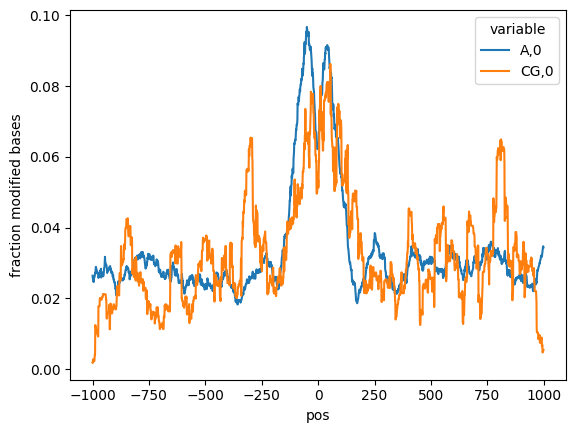

In [24]:
plot_enrichment_profile.by_modification(
    mod_file_name=pileup_file,
    bed_file_name=ctcf_target_regions,
    window_size=1000,
    mod_names=['A,0','CG,0'],
    smooth_window=50
)

## Plot Enrichment

In [29]:
from dimelo import plot_enrichment

/Users/jeremy/miniconda3/envs/dimelo_modkit_parsing/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jeremy/miniconda3/envs/dimelo_modkit_parsing/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='fraction modified bases'>

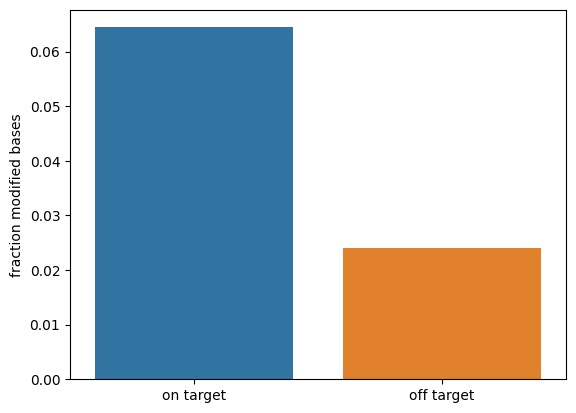

In [31]:
plot_enrichment.plot_enrichment(mod_file_names=[pileup_file_on_target, pileup_file_off_target],
                                bed_file_names=[ctcf_target_regions, ctcf_off_target_regions],
                                mod_names=['A,0', 'A,0'],
                                sample_names=['on target', 'off target'])

## Plot Reads

In [33]:
from dimelo import plot_reads

Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed


<Axes: xlabel='pos', ylabel='read_name'>

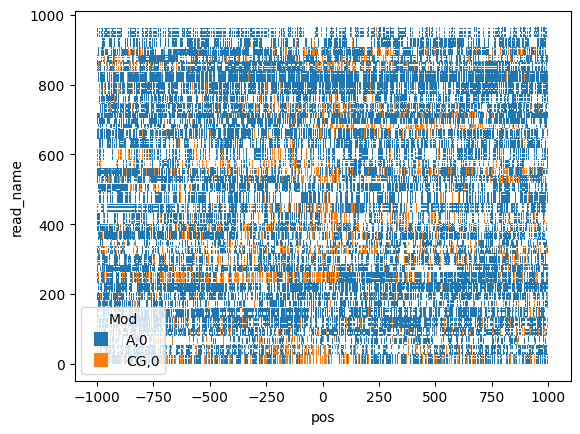

In [34]:
plot_reads.plot_reads(
    mod_file_name=extract_file,
    bed_file_name=ctcf_target_regions,
    mod_names=['A,0', 'CG,0'],
    window_size=1000
)
